In [82]:
import pickle
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import os
import requests
import json
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib
import getpass
import warnings
import pandas
import time
import subprocess
import logging
import webbrowser
import glob
from datetime import *
import scipy.signal
np.random.seed(1)
import sqlite3

In [2]:
from os import listdir
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
f = ascii.read("SLSNe - I.txt")
targets = f['col1']
redshift = f['col4']
print (targets)
print (redshift)

    col1    
------------
ZTF18abszecm
ZTF18acenqto
ZTF19aawsqsc
ZTF19aaqrime
 col4 
------
  0.44
 0.166
  0.26
0.3562


In [38]:
#targets = ["ZTF18abszecm", "ZTF18acenqto","ZTF19aawsqsc","ZTF19aaqrime"]

#More_targets= ["ZTF19aarphwc","ZTF19abaeyqw","ZTF18aaisyyp","ZTF18aajqcue","ZTF18aapgrxo","ZTF18aavrmcg","ZTF18aazgrfl",
#"ZTF18abjwagv","ZTF18ablwafp","ZTF18abmasep","ZTF18abrzcbp","ZTF18abshezu","ZTF18abvgjyl","ZTF18acapyww",
#"ZTF18achdidy","ZTF18acqyvag","ZTF18acslpji","ZTF18acyxnyw","ZTF19aacxrab","ZTF19aajwogx","ZTF19aaknqmp",
#"ZTF19aamhhiz","ZTF19aanesgt","ZTF19aantokv","ZTF19aaohuwc","ZTF19aapaeye","ZTF19aaruixj","ZTF19aasdvfr",
#"ZTF19aauiref","ZTF19aayclnm","ZTF19abdlzyq","ZTF19abfvnns"]

In [4]:
rcf_target = ["ZTF18acxgqxq"]

In [5]:
def fetch_ZTF_spectrum(target_id, user, passw, specfilter=False, program_idx=0):
    """Returns list of all available spectra(data url paths) for a given ZTF target.

    Input
    ------
    target_id: ZTF name of source (str)
    user: Username for login cridentials for GROWTH Marshall (str)
    passw: Password for login cridentials for GROWTH Marshall (str)
    specfilter: True; Choose a single spectrum based of of the peak magnitude (PM) (+7 days after PM or -4 before PM) (bool)
    specfilter: False; Choose multiple spectra uploaded in the Marshall (bool)

    Output
    ------
    list_spec: List of download paths (from marshall) in format: spectra/data/ZTFid_date_inst_vn.ascii (list)
    """

    programidx = program_idx # CLU:0
    r = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi', auth=(user, passw), data = {'programidx': str(programidx)})
    sources_clu = json.loads(r.text) # preliminary information on CLU objects
    list_spec, sd, dat_url, dat_inst = [], [], [], []

    for i in enumerate(sources_clu):
        name = i[1]['name'] # name generated from marshall

        if name == target_id: # if you find the ZTF_id you have queried
            marsh_info = i[1] # fetch marshall information!
            s = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/source_summary.cgi', auth=(user, passw), data = {'sourceid': str(marsh_info['id'])})
            sourceDict = json.loads(s.text)

            # Spectral and Photometric information --
            spec = sourceDict['uploaded_spectra'] # information on spectroscopy
            photometry_info = sourceDict['uploaded_photometry'] # information on photometry

            N_spec = len(spec) # number of available spectra! -- check for uniqueness? [NOTE!]
            
            for spectra_path in spec:
                list_spec.append(str(spectra_path['datapath'])) # append datapaths...
            return (list_spec)

In [6]:
def download_spectra(data_path, target_id, date_dir_name, dtype='no_header'):
    """Downloads .ascii files from GROWTH Marshall for given ZTF object.

    Input
    -----
    data_path: Download URL from GROWTH Marshall -- usually called from Fetch_ZTF_Spectrum (str)
    target_id: ZTF name of source (str)
    date_dir_name: daving date directory you will be storing the downloaded files (str)
    dtype: data type you want for the ascii files. Usually no_header will not read the first row of the ascii file.

    Output
    ------
    Creates /spectra and /summary directories and downloads ascii file data path given.

    """
    # GROWTH Marshall url where data is available
    download_url = "http://skipper.caltech.edu:8080/growth-data/"

    # Complete path to url downloading data
    data_path_mod = data_path.split("/")[2].split('.')[0] #ZTFid_date_inst_vn

    try:
        # Stich final directories to the directory containing the data
        final_path_to_data = download_url + "spectra/data/" + data_path_mod + ".ascii"
        print ("this is the final path --> ")
        print (final_path_to_data)
    except:
        print ("This file you have requested is not available!")
        return (None)

    # Make a new directory with the ZTF name
    bash1 = subprocess.run("mkdir data/%s/%s"%(date_dir_name, target_id), shell=True)
    bash2 = subprocess.run("mkdir data/%s/%s/spectra"%(date_dir_name, target_id), shell=True) # create the spectra dir in the ZTF target dir

    # Fetch data from custom url
    data = ascii.read("%s"%final_path_to_data, format=dtype)
    # clean from nan values
    rmv_nan = np.where(np.isnan([data['col1'], data['col2']]))
    data.remove_rows(rmv_nan[1]) # will remove NaN identified values!
    min_lambda = min(data['col1']) # minimum wavelength
    max_lambda = max(data['col1'])# maximum wavelength

    # Generally in this directory we will have: ".asii", ".output"
    download_spectrum = ascii.write(data, "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod), format=dtype)
    stored_spectrum = "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod)
    return (stored_spectrum)

In [75]:
user = "AishwaryaD"
passw = "bBrA@7592"

# Where will the data be stored from this python run? format: month/day/year (i.e 07022019)
date_directory= "trial"#input("Create a new date-directory (i.e 07202019): ")
mkdir_date_dir = os.system("mkdir data/%s"%date_directory) # make a new directory where we will store the datapath


program_index = "10"


for target in targets:
    print (target)
    
    spectra = fetch_ZTF_spectrum(target, user, passw, program_idx=10)
    print (spectra)
    
    for spec in spectra:
        spec_download = download_spectra(spec, target, date_directory) # download all spectra to data path
        print (spec_download)
       
    out_files_path = glob.glob("data/%s/%s/spectra/*.ascii"%(date_directory, target))

ZTF18abszecm
['spectra/data/ZTF18abszecm_20181213_P200_v3.ascii', 'spectra/data/ZTF18abszecm_20180913_P200_v1.fits', 'spectra/data/ZTF18abszecm_20181213_P200_v1.ascii', 'spectra/data/ZTF18abszecm_20181111_Keck1_v1.ascii', 'spectra/data/ZTF18abszecm_20190829_Keck1_v2.ascii', 'spectra/data/ZTF18abszecm_20190702_Keck1_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20181213_P200_v3.ascii
data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20181213_P200_v3.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20180913_P200_v1.ascii
data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20180913_P200_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20181213_P200_v1.ascii


data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20181213_P200_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20181111_Keck1_v1.ascii
data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20181111_Keck1_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20190829_Keck1_v2.ascii


data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20190829_Keck1_v2.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18abszecm_20190702_Keck1_v1.ascii
data/trial/ZTF18abszecm/spectra/ZTF18abszecm_20190702_Keck1_v1.ascii
ZTF18acenqto


['spectra/data/ZTF18acenqto_20181209_P60_v1.ascii', 'spectra/data/ZTF18acenqto_20181201_Keck1_v1.ascii', 'spectra/data/ZTF18acenqto_20190126_NOT_v1.fits', 'spectra/data/ZTF18acenqto_20181212_P60_v1.ascii', 'spectra/data/ZTF18acenqto_20181213_P200_v1.fits', 'spectra/data/ZTF18acenqto_20190110_VLT_v1.ascii', 'spectra/data/ZTF18acenqto_20190107_NOT_v1.fits', 'spectra/data/ZTF18acenqto_20181228_P60_v1.ascii', 'spectra/data/ZTF18acenqto_20181228_P60_v2.ascii', 'spectra/data/ZTF18acenqto_20190211_VLT_v1.ascii', 'spectra/data/ZTF18acenqto_20190222_NOT_v1.fits', 'spectra/data/ZTF18acenqto_20190823_NTT_v1.fits', 'spectra/data/ZTF18acenqto_20190829_Keck1_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181209_P60_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181209_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181201_Keck1_v1.ascii


data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181201_Keck1_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190126_NOT_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190126_NOT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181212_P60_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181212_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181213_P200_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181213_P200_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190110_VLT_v1.ascii


data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190110_VLT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190107_NOT_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190107_NOT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181228_P60_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181228_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20181228_P60_v2.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20181228_P60_v2.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190211_VLT_v1.ascii


data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190211_VLT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190222_NOT_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190222_NOT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190823_NTT_v1.ascii
data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190823_NTT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acenqto_20190829_Keck1_v1.ascii


data/trial/ZTF18acenqto/spectra/ZTF18acenqto_20190829_Keck1_v1.ascii
ZTF19aarphwc
['spectra/data/ZTF19aarphwc_20190524_P200_v1.ascii', 'spectra/data/ZTF19aarphwc_20190619_P60_v1.ascii', 'spectra/data/ZTF19aarphwc_20190703_P200_v1.ascii', 'spectra/data/ZTF19aarphwc_20190907_Keck2_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aarphwc_20190524_P200_v1.ascii
data/trial/ZTF19aarphwc/spectra/ZTF19aarphwc_20190524_P200_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aarphwc_20190619_P60_v1.ascii
data/trial/ZTF19aarphwc/spectra/ZTF19aarphwc_20190619_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aarphwc_20190703_P200_v1.ascii


data/trial/ZTF19aarphwc/spectra/ZTF19aarphwc_20190703_P200_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aarphwc_20190907_Keck2_v1.ascii


data/trial/ZTF19aarphwc/spectra/ZTF19aarphwc_20190907_Keck2_v1.ascii
ZTF19aawsqsc
['spectra/data/ZTF19aawsqsc_20190702_Keck1_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aawsqsc_20190702_Keck1_v1.ascii
data/trial/ZTF19aawsqsc/spectra/ZTF19aawsqsc_20190702_Keck1_v1.ascii
ZTF19aavouyw


['spectra/data/ZTF19aavouyw_20190604_LT_v1.ascii', 'spectra/data/ZTF19aavouyw_20190613_P60_v1.ascii', 'spectra/data/ZTF19aavouyw_20190619_P60_v1.ascii', 'spectra/data/ZTF19aavouyw_20190701_P200_v1.ascii', 'spectra/data/ZTF19aavouyw_20190702_Keck1_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aavouyw_20190604_LT_v1.ascii
data/trial/ZTF19aavouyw/spectra/ZTF19aavouyw_20190604_LT_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aavouyw_20190613_P60_v1.ascii
data/trial/ZTF19aavouyw/spectra/ZTF19aavouyw_20190613_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aavouyw_20190619_P60_v1.ascii
data/trial/ZTF19aavouyw/spectra/ZTF19aavouyw_20190619_P60_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF19aavouyw_20190701_P200_v1.ascii
data/trial/ZTF19aavouyw/spectra/ZTF19aavouyw_20190701_P200_v1.

data/trial/ZTF19aavouyw/spectra/ZTF19aavouyw_20190702_Keck1_v1.ascii


In [21]:
user = "AishwaryaD"
passw = "bBrA@7592"

# Where will the data be stored from this python run? format: month/day/year (i.e 07022019)
date_directory= "rcf"#input("Create a new date-directory (i.e 07202019): ")
mkdir_date_dir = os.system("mkdir data/%s"%date_directory) # make a new directory where we will store the datapath


program_index = "0"

for t in rcf_target:
    
    spectra = fetch_ZTF_spectrum(t, user, passw, program_idx=0)
    print (spectra)
    
    for spec in spectra:
        spec_download = download_spectra(spec, t, date_directory) # download all spectra to data path
        print (spec_download)
       
    out_files_path = glob.glob("data/%s/%s/spectra/*.ascii"%(date_directory, t))

['spectra/data/ZTF18acxgqxq_20190107_P200_v2.ascii', 'spectra/data/ZTF18acxgqxq_20190104_Keck1_v1.ascii', 'spectra/data/ZTF18acxgqxq_20190702_Keck1_v1.ascii']
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acxgqxq_20190107_P200_v2.ascii
Looking in wavelength ranges: 3300.0 - 10000.85
data/rcf/ZTF18acxgqxq/spectra/ZTF18acxgqxq_20190107_P200_v2.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acxgqxq_20190104_Keck1_v1.ascii
Looking in wavelength ranges: 5456.1763 - 10310.52
data/rcf/ZTF18acxgqxq/spectra/ZTF18acxgqxq_20190104_Keck1_v1.ascii
this is the final path --> 
http://skipper.caltech.edu:8080/growth-data/spectra/data/ZTF18acxgqxq_20190702_Keck1_v1.ascii
Looking in wavelength ranges: 3087.0605 - 10307.219
data/rcf/ZTF18acxgqxq/spectra/ZTF18acxgqxq_20190702_Keck1_v1.ascii


In [150]:
plotx = []
ploty = []

label = [[],[]]
text = []
rest = []

for t in targets:
    
    variable = t
    print (variable)
    r = redshift[np.where(variable == targets)]
    z = (1 + r)
    print (z)
    rest= np.append(rest, z)
    print(rest)

    directory = glob.glob("data/trial/%s/spectra/*.ascii"%t)
    
    for d in directory:


        #if d.split("_")[0] == t:
        #if d == t:
        #print (d)

        l = d.split("/")[4]
        print (l)


        label = (l.split("_")[0] +" "+ l.split("_")[1])
        text.append(label)

        data = ascii.read(d)
        data_l, data_flux = data['col1'], data['col2'] # first define as variables

        data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # update the variables with 
        data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)]

        lam_cut = np.where((data_l>6000) & (data_l<7000))

        print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
        mean = np.mean(data_flux[lam_cut])

        plotx.append(data_l)
        ploty.append(data_flux/mean)

            #idx  = (data["col1"]>6000) & (data["col1"]<7000)
            #mean = data["col2"][idx].mean()
            #print (mean)

ZTF18abszecm
col4
----
1.44
[1.44]
ZTF18abszecm_20180913_P200_v1.ascii
The mean you're selecting: 2.931807621951219e-17
ZTF18abszecm_20181111_Keck1_v1.ascii
The mean you're selecting: 1.6284975477712265e-17
ZTF18abszecm_20181213_P200_v1.ascii
The mean you're selecting: 3.664496341463415e-17
ZTF18abszecm_20181213_P200_v3.ascii
The mean you're selecting: 3.087832877300614e-17
ZTF18abszecm_20190702_Keck1_v1.ascii
The mean you're selecting: 9.566415997652581e-18
ZTF18abszecm_20190829_Keck1_v2.ascii
The mean you're selecting: 3.66449343094959e-18
ZTF18acenqto
 col4
-----
1.166
[1.44  1.166]
ZTF18acenqto_20181201_Keck1_v1.ascii
The mean you're selecting: 1.3492835971896956e-16
ZTF18acenqto_20181209_P60_v1.ascii
The mean you're selecting: 3.0747749999999996e-15
ZTF18acenqto_20181212_P60_v1.ascii
The mean you're selecting: 1.3367000000000002e-15
ZTF18acenqto_20181213_P200_v1.ascii
The mean you're selecting: 2.1236032012195124e-16
ZTF18acenqto_20181228_P60_v1.ascii
The mean you're selecting: 1.

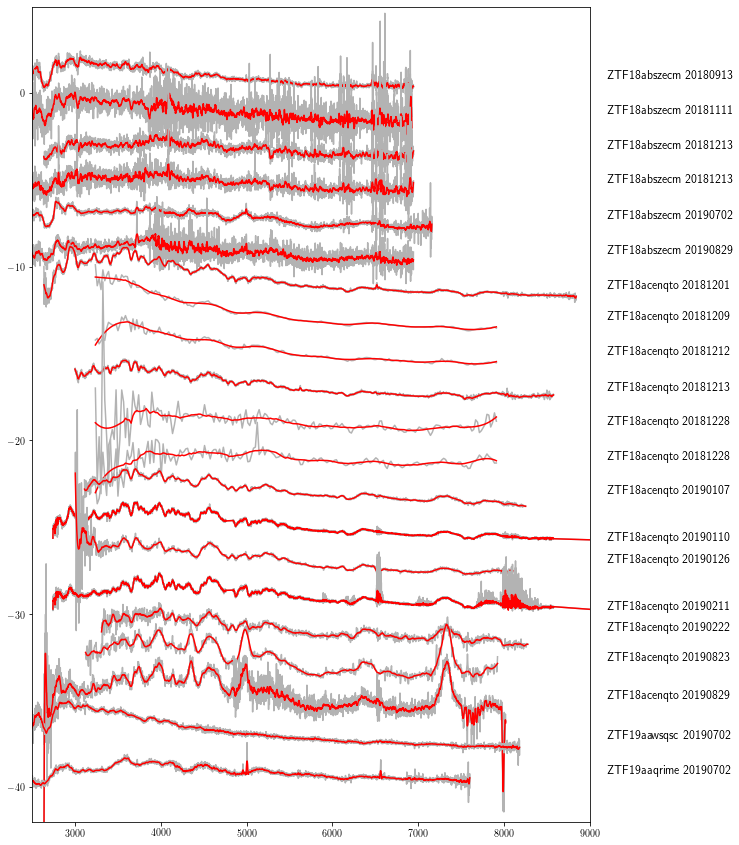

In [168]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,15))
ax.set_xlim(2500,9000)
ax.set_ylim(-42, 5)
#plt.yscale('log')

l = 0

count = 0
for k in zip(plotx,ploty):
    yhat = scipy.signal.savgol_filter(k[1], 31, 3)

    # Plotting the spectrum name and date for every spectrum
    y_temp = k[1] + l 
    text_pos_y = np.median(y_temp)
    #text_pos_y = y_temp[plotx[9500]]
    ax.text(9200, text_pos_y, text[count], size=12)

    variable = text[count].split(" ")[0]
    #print (variable)
    r = redshift[np.where(variable == targets)]
    z = (1 + r)
    #print (z)

    count = count+1
    ax.plot(k[0]/z, k[1]+l,  color = '0.7')
    ax.plot(k[0]/z, yhat+l, color='red')
    #ax.set_xlim(3400, 8200)

    l += -2

plt.show()
